In [1]:
!pip install transformers datasets torch scikit-learn


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
from transformers import AlbertForSequenceClassification, Trainer, TrainingArguments, AlbertTokenizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support


In [3]:
from google.colab import files
uploaded = files.upload()

Saving shakespeare-sentiment.csv to shakespeare-sentiment.csv


In [4]:
from google.colab import files
uploaded = files.upload()

Saving test_sent_emo.csv to test_sent_emo.csv


In [5]:
# Load the datasets
shakespeare_df = pd.read_csv('shakespeare-sentiment.csv')
test_sent_emo_df = pd.read_csv('test_sent_emo.csv')

In [6]:
# Map sentiment labels to numeric values
label_mapping = {'positive': 0, 'neutral': 1, 'negative': 2}
# Apply the mapping to both datasets
shakespeare_df['sentiment'] = shakespeare_df['sentiment'].map(label_mapping)
test_sent_emo_df['Sentiment'] = test_sent_emo_df['Sentiment'].map(label_mapping)
# Remove rows with missing labels in both datasets
shakespeare_df = shakespeare_df.dropna(subset=['sentiment'])
test_sent_emo_df = test_sent_emo_df.dropna(subset=['Sentiment'])

# Verify the mapping and check if it's done correctly
print("Shakespeare Sentiment unique values after mapping:", shakespeare_df['sentiment'].unique())
print("test_sent_emo Sentiment unique values after mapping:", test_sent_emo_df['Sentiment'].unique())

Shakespeare Sentiment unique values after mapping: []
test_sent_emo Sentiment unique values after mapping: [0 2 1]


In [7]:
# Load the Shakespeare Sentiment Dataset
shakespeare_sentiment = pd.read_csv('shakespeare-sentiment.csv')

# Step 1: Preprocess Shakespeare Sentiment Dataset
# Remove rows with missing values in the 'sentiment' column
shakespeare_sentiment_clean = shakespeare_sentiment.dropna(subset=['sentiment'])

# Map string labels to numeric values (POSITIVE=0, NEUTRAL=1, NEGATIVE=2)
label_mapping = {"POSITIVE": 0, "NEUTRAL": 1, "NEGATIVE": 2}

# Apply the mapping to the 'sentiment' column
shakespeare_sentiment_clean['sentiment'] = shakespeare_sentiment_clean['sentiment'].map(label_mapping)

# Verify the mapping and check the unique values
print("Shakespeare Sentiment unique values after mapping:", shakespeare_sentiment_clean['sentiment'].unique())

# Check the first few rows to verify the data
print(shakespeare_sentiment_clean[['text', 'sentiment']].head())

Shakespeare Sentiment unique values after mapping: [0 1 2]
                                                text  sentiment
0  With no fees or minimums, banking with Capital...          0
1  And with no overdraft fees, is it even a decis...          1
2                       What's in your wallet terms?          1
3                                             Apply.          1
4  See capitalone.com Slash Bank Capital one NA m...          0


In [8]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize and format data properly
def tokenize_data(texts, labels):
    encodings = tokenizer(list(texts), padding=True, truncation=True, max_length=128, return_tensors="pt")
    encodings['labels'] = torch.tensor(labels.values)
    return encodings

# Split the Shakespeare dataset
X_train_s, X_temp_s, y_train_s, y_temp_s = train_test_split(shakespeare_sentiment_clean['text'], shakespeare_sentiment_clean['sentiment'], test_size=0.2, random_state=42)
X_val_s, X_test_s, y_val_s, y_test_s = train_test_split(X_temp_s, y_temp_s, test_size=0.5, random_state=42)

# Tokenize the Shakespeare dataset
train_encodings_s = tokenize_data(X_train_s, y_train_s)
val_encodings_s = tokenize_data(X_val_s, y_val_s)
test_encodings_s = tokenize_data(X_test_s, y_test_s)

# Convert the tokenized data into a Dataset format required by the Trainer
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

# Convert encodings to dataset format
train_dataset_s = SentimentDataset(train_encodings_s)
val_dataset_s = SentimentDataset(val_encodings_s)
test_dataset_s = SentimentDataset(test_encodings_s)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize and format data properly
def tokenize_data(texts, labels):
    encodings = tokenizer(list(texts), padding=True, truncation=True, max_length=128, return_tensors="pt")
    encodings['labels'] = torch.tensor(labels.values)
    return encodings

# Split the Shakespeare dataset
X_train_s, X_temp_s, y_train_s, y_temp_s = train_test_split(shakespeare_sentiment_clean['text'], shakespeare_sentiment_clean['sentiment'], test_size=0.2, random_state=42)
X_val_s, X_test_s, y_val_s, y_test_s = train_test_split(X_temp_s, y_temp_s, test_size=0.5, random_state=42)

# Tokenize the Shakespeare dataset
train_encodings_s = tokenize_data(X_train_s, y_train_s)
val_encodings_s = tokenize_data(X_val_s, y_val_s)
test_encodings_s = tokenize_data(X_test_s, y_test_s)



In [12]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np

# Load the RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",        # Save model at the end of each epoch
     gradient_accumulation_steps=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,           # Adjust the number of epochs as needed
    learning_rate=2e-5,           # Adjust the learning rate if needed
    weight_decay=0.02,
    load_best_model_at_end=True   # Load the best model at the end of training
)



# Compute class weights (optional, if classes are imbalanced)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_s), y=y_train_s)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Define a custom loss function to incorporate class weights
def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

# Function to compute accuracy, precision, recall, and F1-score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = np.mean(preds == labels)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
trainer_s = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_s,
    eval_dataset=val_dataset_s,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Include the metrics
)

# Set the custom loss function
trainer_s.compute_loss = compute_loss

# Train the model on the Shakespeare dataset
trainer_s.train()

# Evaluate the model on validation and test sets
shakespeare_val_results = trainer_s.evaluate(val_dataset_s)
shakespeare_test_results = trainer_s.evaluate(test_dataset_s)
# Print validation and test results
print("Shakespeare Sentiment Dataset Validation Results:", shakespeare_val_results)
print("Shakespeare Sentiment Dataset Test Results:", shakespeare_test_results)

# Save the best model
trainer_s.save_model("./best_shakespeare_model")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 33


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-8-a12e0444bec1>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,1.056451,0.636364,0.541100,0.636364,0.579998
1,No log,0.651723,0.636364,0.720708,0.636364,0.630988
2,No log,0.538238,0.779221,0.799070,0.779221,0.782510
4,No log,0.507356,0.792208,0.801793,0.792208,0.794365
5,No log,0.576963,0.753247,0.774754,0.753247,0.757001
6,No log,0.883841,0.792208,0.789453,0.792208,0.789487
8,No log,0.911272,0.805195,0.803568,0.805195,0.801539
9,No log,1.336578,0.831169,0.849962,0.831169,0.820395
10,No log,0.849207,0.818182,0.825893,0.818182,0.819770
12,No log,1.227007,0.818182,0.815742,0.818182,0.813627


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-8-a12e0444bec1>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-a12e0444bec1>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-a12e0444bec1>:35: UserWarning: To copy construct

<ipython-input-8-a12e0444bec1>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Shakespeare Sentiment Dataset Validation Results: {'eval_loss': 0.5073562264442444, 'eval_accuracy': 0.7922077922077922, 'eval_precision': 0.8017934446505873, 'eval_recall': 0.7922077922077922, 'eval_f1': 0.7943651913496703, 'eval_runtime': 0.441, 'eval_samples_per_second': 174.617, 'eval_steps_per_second': 22.678, 'epoch': 14.805194805194805}
Shakespeare Sentiment Dataset Test Results: {'eval_loss': 0.35378435254096985, 'eval_accuracy': 0.9090909090909091, 'eval_precision': 0.9166389166389166, 'eval_recall': 0.9090909090909091, 'eval_f1': 0.9104033451859539, 'eval_runtime': 0.3418, 'eval_samples_per_second': 225.249, 'eval_steps_per_second': 29.253, 'epoch': 14.805194805194805}


In [14]:
# Tokenize the `test_sent_emo` dataset
X_train_e, X_temp_e, y_train_e, y_temp_e = train_test_split(test_sent_emo_df['Utterance'], test_sent_emo_df['Sentiment'], test_size=0.2, random_state=42)
X_val_e, X_test_e, y_val_e, y_test_e = train_test_split(X_temp_e, y_temp_e, test_size=0.5, random_state=42)

def tokenize_data(texts, labels):
    encodings = tokenizer(list(texts), padding=True, truncation=True, max_length=128, return_tensors="pt")
    encodings['labels'] = torch.tensor(labels.values)
    return encodings

# Tokenize the test_sent_emo dataset
train_encodings_e = tokenize_data(X_train_e, y_train_e)
val_encodings_e = tokenize_data(X_val_e, y_val_e)
test_encodings_e = tokenize_data(X_test_e, y_test_e)

# Convert to Dataset format for Trainer
class SentimentDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

# Convert encodings to dataset format
train_dataset_e = SentimentDataset(train_encodings_e)
val_dataset_e = SentimentDataset(val_encodings_e)
test_dataset_e = SentimentDataset(test_encodings_e)


In [15]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


In [19]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments, RobertaTokenizer
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np

# Load the RoBERTa model for sequence classification
model_emo = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Define training arguments for test_sent_emo dataset
training_args_emo = TrainingArguments(
    output_dir='./results_emo',
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save model at the end of each epoch
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    num_train_epochs=15,  # Set to  epochs
    learning_rate=2e-5,  # Adjust learning rate
    weight_decay=0.02,
    warmup_steps=500,
    load_best_model_at_end=True,  # Load the best model at the end
)

# Compute class weights for the sentiment labels
class_weights_emo = compute_class_weight('balanced', classes=np.unique(y_train_e), y=y_train_e)
class_weights_tensor_emo = torch.tensor(class_weights_emo, dtype=torch.float)

# Define custom loss function for test_sent_emo dataset
def compute_loss_e(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor_emo.to(model.device))
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

    from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Function to compute accuracy, precision, recall, and f1
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=1)
    accuracy = accuracy_score(labels, preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Trainer setup for test_sent_emo dataset with metrics
trainer_e = Trainer(
    model=model_emo,
    args=training_args_emo,
    train_dataset=train_dataset_e,
    eval_dataset=val_dataset_e,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Include metrics (accuracy, precision, recall, F1-score)
)

# Set the custom loss function
trainer_e.compute_loss = compute_loss_e

# Train the model on the test_sent_emo dataset
trainer_e.train()

# Evaluate the model on the validation and test sets
test_sent_emo_val_results = trainer_e.evaluate(val_dataset_e)
test_sent_emo_test_results = trainer_e.evaluate(test_dataset_e)

# Print validation and test results
print("test_sent_emo Dataset Validation Results:", test_sent_emo_val_results)
print("test_sent_emo Dataset Test Results:", test_sent_emo_test_results)

# Save the best model
trainer_e.save_model("./best_test_sent_emo_model")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-14-256ebe264105>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,1.101158,0.187739,0.653047,0.187739,0.076814
1,No log,1.070537,0.544061,0.579243,0.544061,0.500375
2,No log,0.844690,0.639847,0.633395,0.639847,0.627192
4,No log,0.688060,0.670498,0.702058,0.670498,0.676641
5,No log,0.727000,0.716475,0.711294,0.716475,0.705875
6,No log,0.931871,0.636015,0.680353,0.636015,0.639928
8,0.794200,1.010677,0.674330,0.685655,0.674330,0.673334
9,0.794200,1.176601,0.704981,0.711372,0.704981,0.707683
10,0.794200,1.233118,0.697318,0.708909,0.697318,0.700214
12,0.794200,1.372772,0.685824,0.695093,0.685824,0.687527


<ipython-input-14-256ebe264105>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-14-256ebe264105>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-14-256ebe264105>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-14-256ebe264105>:24: UserWarning: To copy construct fro

<ipython-input-14-256ebe264105>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


test_sent_emo Dataset Validation Results: {'eval_loss': 0.6880595088005066, 'eval_accuracy': 0.6704980842911877, 'eval_precision': 0.7020580882418962, 'eval_recall': 0.6704980842911877, 'eval_f1': 0.6766405100649743, 'eval_runtime': 0.7704, 'eval_samples_per_second': 338.789, 'eval_steps_per_second': 42.835, 'epoch': 14.942528735632184}
test_sent_emo Dataset Test Results: {'eval_loss': 0.7672197818756104, 'eval_accuracy': 0.6934865900383141, 'eval_precision': 0.7017873384180184, 'eval_recall': 0.6934865900383141, 'eval_f1': 0.6952479014789964, 'eval_runtime': 0.6905, 'eval_samples_per_second': 377.995, 'eval_steps_per_second': 47.793, 'epoch': 14.942528735632184}


<ipython-input-8-a12e0444bec1>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Shakespeare Sentiment Dataset Test Evaluation Results:
{'accuracy': 0.9090909090909091, 'precision': 0.9166389166389166, 'recall': 0.9090909090909091, 'f1': 0.9104033451859539, 'roc_auc': None}


<ipython-input-14-256ebe264105>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


test_sent_emo Dataset Test Evaluation Results:
{'accuracy': 0.6934865900383141, 'precision': 0.7017873384180184, 'recall': 0.6934865900383141, 'f1': 0.6952479014789964, 'roc_auc': None}


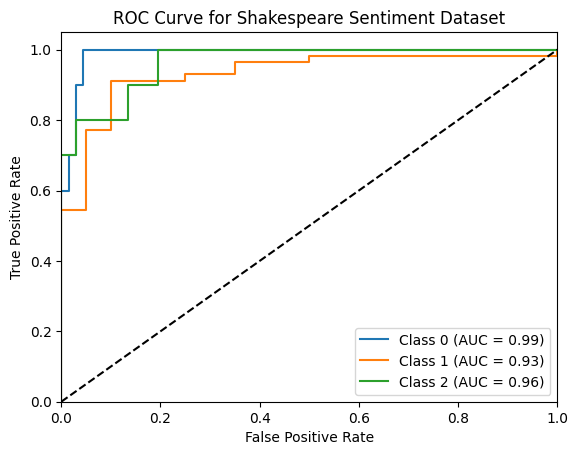

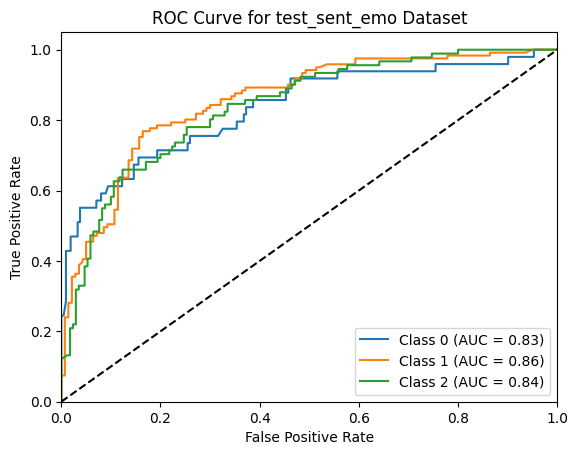

In [20]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from transformers import Trainer

# Function to calculate metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    # AUC ROC curve
    try:
        roc_auc = roc_auc_score(labels, pred.predictions, multi_class='ovr')
    except ValueError:
        roc_auc = None  # Handle the case where ROC AUC can't be calculated

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

# Function to plot ROC curve
def plot_roc_curve(predictions, labels, dataset_name):
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(3):  # Assuming 3 classes (Positive, Neutral, Negative)
        fpr[i], tpr[i], _ = roc_curve(labels == i, predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(3):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

# Predictions and metrics for the Shakespeare Sentiment dataset using RoBERTa
shakespeare_pred = trainer_s.predict(test_dataset_s)
shakespeare_metrics = compute_metrics(shakespeare_pred)
print("Shakespeare Sentiment Dataset Test Evaluation Results:")
print(shakespeare_metrics)

# Predictions and metrics for the test_sent_emo dataset using RoBERTa
test_sent_emo_pred = trainer_e.predict(test_dataset_e)
test_sent_emo_metrics = compute_metrics(test_sent_emo_pred)
print("test_sent_emo Dataset Test Evaluation Results:")
print(test_sent_emo_metrics)

# Plot ROC curve for Shakespeare Sentiment dataset
plot_roc_curve(shakespeare_pred.predictions, shakespeare_pred.label_ids, "Shakespeare Sentiment Dataset")

# Plot ROC curve for test_sent_emo dataset
plot_roc_curve(test_sent_emo_pred.predictions, test_sent_emo_pred.label_ids, "test_sent_emo Dataset")
